<a href="https://colab.research.google.com/github/w-decker/NMA_DL_Project/blob/main/NMA_DL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NMA DL Project

In [ ]:
# @title Installations

# @markdown Some packages may need to be installed (e.g., `nilearn`). Type them in below and run the cell.

install = "nilearn" # @param{type: "string"}

!pip install {install} --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 18.2 MB/s eta 0:00:00


In [ ]:
import torch
from torchvision import transforms
from torchvision.models import alexnet as alexnet
from torch.utils.data import Dataset, DataLoader

import numpy as np
import numpy.typing as npt

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
%matplotlib inline

import nibabel as nib
from nilearn import plotting

import requests, os, tarfile

from tqdm.auto import tqdm

from PIL import Image

In [ ]:
# @title Helper functions

def set_device(device:str=None) -> str:
  """Set device

  Paremeters
  ----------
  device: str
    "cuda" or "cpu"

  Return
  ------
  device: str
  """
  assert device == 'cuda' or 'cpu' or None

  if device is None:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
  else:
    device = device

  return device

def download_kay():
  """Download dataset from Kay and Gallant"""

  fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]
  urls = ["https://osf.io/r638s/download",
      "https://osf.io/yqb3e/download",
      "https://osf.io/ymnjv/download"]

  for fname, url in zip(fnames, urls):
    if not os.path.isfile(fname):
      try:
        r = requests.get(url)
      except requests.ConnectionError:
        print("!!! Failed to download data !!!")
      else:
        if r.status_code != requests.codes.ok:
          print("!!! Failed to download data !!!")
        else:
          print(f"Downloading {fname}...")
          with open(fname, "wb") as fid:
            fid.write(r.content)
          print(f"Download {fname} completed!")

def kay_exists() -> bool:
  """Check that Kay and Gallant dataset exists"""

  fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]

  return all(map(os.path.exists, fnames))


def load_kay() -> dict | np.ndarray | np.ndarray:
  """Load dataset from Kay and Gallant into workspace"""

  with np.load( "kay_images.npz") as dobj:
    dat = dict(**dobj)
    labels = np.load('kay_labels.npy')
    val_labels = np.load('kay_labels_val.npy')

  return dat, labels, val_labels

def random_image(data:dict):
  """Choose random image from stimuli"""
  idx = np.random.choice(np.arange(0, len(data["stimuli"])), 1)
  print(idx)
  return idx, data["stimuli"][idx, :, :].squeeze(axis=0)



In [ ]:
# @title Initialize some parameters

device = set_device()
print(f'Device: {device}')

Device: cpu


In [ ]:
# @title Download and import data

# download the data
if not kay_exists():
  download_kay()
else:
  print('Data already exists.')

# import data
data, labels, val_labels = load_kay()
print(f'Data loaded as `data`, `labels`, and `val_labels`.')

Data already exists.
Data loaded as `data`, `labels`, and `val_labels`.


# Plot brain data

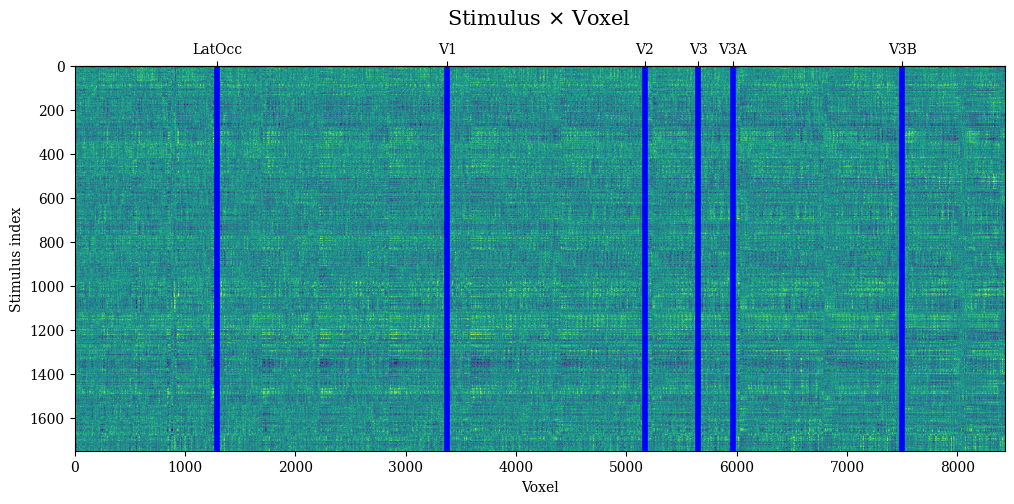

In [ ]:
cmap = 'viridis'

fig, ax = plt.subplots(figsize=(12, 5))
ax.imshow(data['responses'], vmin=-1, vmax=1, aspect='auto',
           cmap=cmap)
ax.set_title(r'Stimulus $\times$ Voxel', pad=30, fontsize=15)
ax.set_xlabel('Voxel')
ax.set_ylabel('Stimulus index')

roi_locs = np.bincount(data["roi"])[1:]
roi_names = ['LatOcc','V1','V2','V3','V3A','V3B','V4']

for roi in np.cumsum(roi_locs[:-1]):
  ax.axvline(roi, color='blue', linewidth=4)

secax = ax.secondary_xaxis('top')
tick_positions = np.cumsum(roi_locs)
secax.set_xticks(tick_positions)
secax.set_xticklabels(roi_names)

plt.show()

# Plot an example stimulus

[1167]


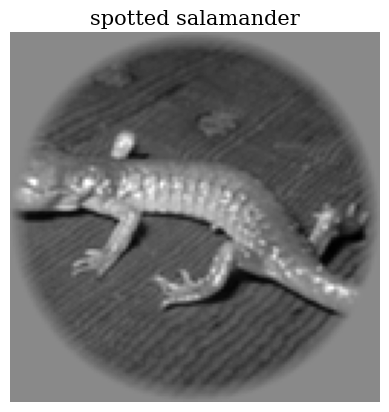

In [ ]:
label_idx, img = random_image(data)
plt.imshow(img, cmap="gray")
plt.title(labels[3, label_idx][0], fontsize=15)
plt.axis('off')
plt.show()

# Load [`AlexNet`](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

In [ ]:
model = alexnet(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Create `Dataset` for images and corresponding labels

**Note:** Each image has a corresponding $4 \times 1$ array of labels, $L$. Rows are. different sets of labels ($4$ in length) generated by work conducted by the authors of the dataset. Here, one label is used ($L_{4, 4}$).

In [ ]:
# reshape
images = data["stimuli"][:, np.newaxis, :, :]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Convert to PIL and apply transformations
transformed_images = torch.stack([transform(Image.fromarray((image[0] * 255).astype(np.uint8))) for image in images])

# labels
labels2 = []
[labels2.append(labels[3, i]) for i in range(len(labels.T))]

# PyTorch cusom dataset
class KayDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

# Create dataset and dataloader
dataset = KayDataset(transformed_images, labels2)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)